# 1D

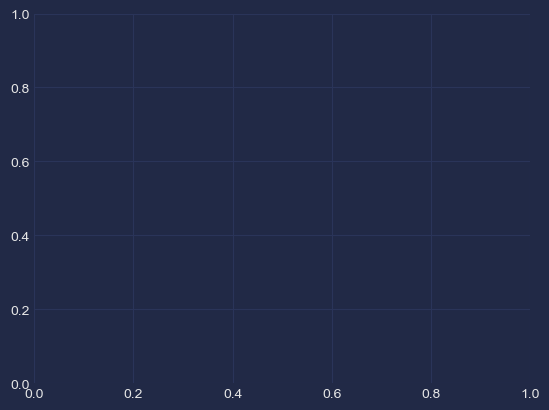

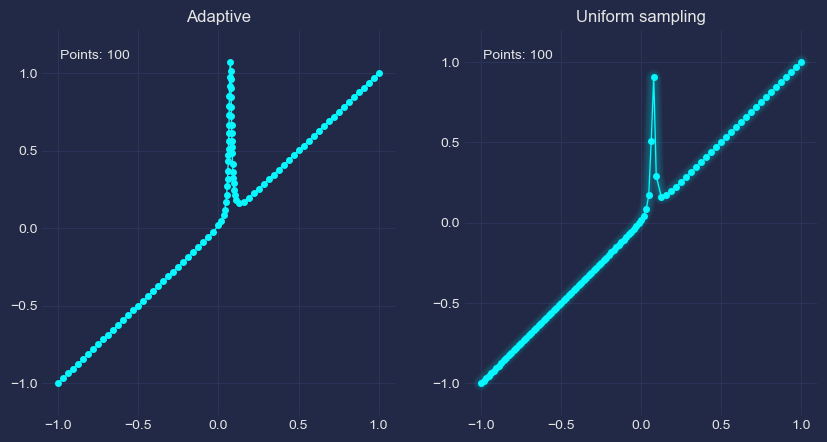

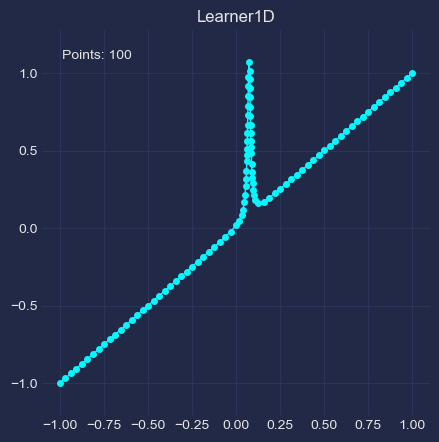

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import adaptive
from adaptive.learner.learner1D import default_loss, uniform_loss
from typing import List, Tuple, Union


def set_style() -> None:
    import mplcyberpunk

    plt.style.use("cyberpunk")
    mplcyberpunk.make_lines_glow()


def f(x: float, offset: float = 0.07357338543088588) -> float:
    a = 0.01
    return x + a**2 / (a**2 + (x - offset) ** 2)


def init_axes(
    ax: plt.Axes, title: str, bounds: Tuple[float, float], data: dict
) -> Tuple[plt.Line2D]:
    margin = 0.05 * (bounds[1] - bounds[0])
    ax.set_xlim(bounds[0] - margin, bounds[1] + margin)
    y_min = min(data.values())
    y_max = max(data.values())
    ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))
    ax.set_title(title)
    return (ax.plot([], [], marker="o", markersize=4, linewidth=1)[0],)


def update(
    frame: int,
    learners: List[adaptive.Learner1D],
    lines: List[plt.Line2D],
    texts: List[plt.Text],
) -> List[Union[plt.Line2D, plt.Text]]:
    for learner, line, text in zip(learners, lines, texts):
        learner_n = learner_till(frame, learner)
        xs, ys = learner_n.to_numpy().T
        line.set_data(xs, ys)
        text.set_text(f"Points: {len(xs)}")
    return lines + texts


def plot_learners(
    learners: List[adaptive.Learner1D], titles: List[str], npoints: int = 100
) -> None:
    set_style()
    n_learners = len(learners)
    fig, axes = plt.subplots(1, n_learners, figsize=(5 * n_learners, 5))
    if n_learners == 1:
        axes = [axes]

    lines = []
    texts = []

    for ax, learner, title in zip(axes, learners, titles):
        (line,) = init_axes(ax, title, learner.bounds, learner.data)
        lines.append(line)
        text = ax.text(0.05, 0.95, "", transform=ax.transAxes, verticalalignment="top")
        texts.append(text)

    ani = FuncAnimation(
        fig,
        update,
        frames=range(1, npoints + 1),
        init_func=lambda: tuple(lines),
        fargs=(learners, lines, texts),
        blit=True,
    )
    ani.save("_vs_".join(titles) + "_animation.mp4", writer="ffmpeg", fps=10)


def plot_learner(learner: adaptive.Learner1D, title: str, npoints: int = 100) -> None:
    plot_learners([learner], [title], npoints)


def compare_learners(
    learner1: adaptive.Learner1D,
    learner2: adaptive.Learner1D,
    title1: str,
    title2: str,
    npoints: int = 100,
) -> None:
    plot_learners([learner1, learner2], [title1, title2], npoints)


def learner_till(npoints: int, learner: adaptive.Learner1D) -> adaptive.Learner1D:
    new_learner = adaptive.Learner1D(
        None, bounds=learner.bounds, loss_per_interval=learner.loss_per_interval
    )
    data = list(learner.data.items())
    new_learner.data = dict(data[:npoints])
    return new_learner


learner = adaptive.Learner1D(f, bounds=(-1, 1), loss_per_interval=default_loss)
learner_uni = adaptive.Learner1D(f, bounds=(-1, 1), loss_per_interval=uniform_loss)

adaptive.runner.simple(learner, npoints_goal=100)
adaptive.runner.simple(learner_uni, npoints_goal=100)

compare_learners(learner, learner_uni, "Adaptive", "Uniform sampling")
plot_learner(learner, "Learner1D")

# 2D single

  0%|          | 0/360 [00:00<?, ?it/s]

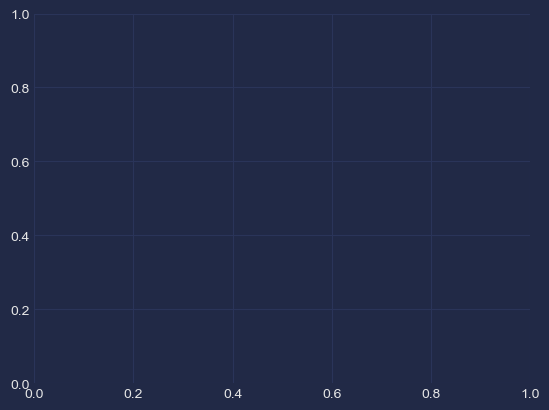

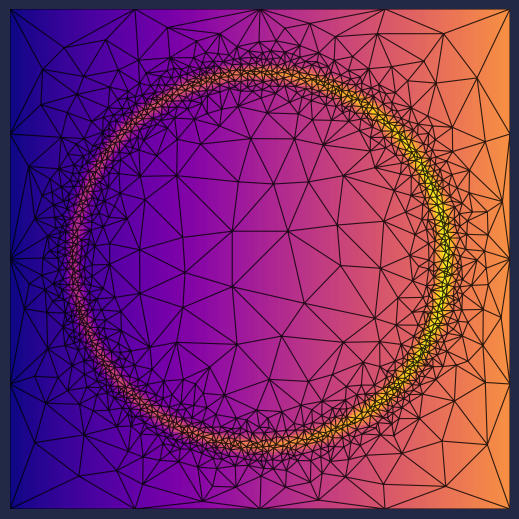

In [8]:
import functools

import matplotlib.tri as mtri
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.animation import FFMpegWriter
from tqdm.auto import tqdm

import adaptive


def set_style() -> None:
    import mplcyberpunk

    plt.style.use("cyberpunk")
    mplcyberpunk.make_lines_glow()

def learner_till(till, learner, data):
    new_learner = adaptive.Learner2D(None, bounds=learner.bounds)
    new_learner.data = dict(data[:till])
    for x, y in learner._bounds_points:
        # always include the bounds
        new_learner.tell((x, y), learner.data[x, y])
    return new_learner


def plot_tri(learner, ax):
    tri = learner.interpolator(scaled=True).tri
    triang = mtri.Triangulation(*tri.points.T, triangles=tri.simplices)
    return ax.triplot(triang, c="k", lw=0.8, alpha=0.8)


def get_new_artists(npoints, learner, data, ax):
    new_learner = learner_till(npoints, learner, data)
    line1, line2 = plot_tri(new_learner, ax)
    data = np.rot90(new_learner.interpolated_on_grid()[-1])
    im = ax.imshow(data, extent=(-0.5, 0.5, -0.5, 0.5), cmap="plasma")
    return im, line1, line2


@functools.lru_cache
def create_and_run_learner():
    def ring(xy):
        import numpy as np

        x, y = xy
        a = 0.2
        return x + np.exp(-((x**2 + y**2 - 0.75**2) ** 2) / a**4)

    learner = adaptive.Learner2D(ring, bounds=[(-1, 1), (-1, 1)])
    adaptive.runner.simple(learner, loss_goal=0.005)
    return learner


def get_figure():
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    return fig, ax


def setup(nseconds=15):
    learner = create_and_run_learner()
    data = list(learner.data.items())
    fig, ax = get_figure()
    npoints = (len(data) * np.linspace(0, 1, 24 * nseconds) ** 2).astype(int)
    return npoints, learner, data, fig, ax


def animate_mp4(fname="source/_static/logo_docs.mp4", nseconds=15):
    set_style()
    npoints, learner, data, fig, ax = setup(nseconds)
    artists = [get_new_artists(n, learner, data, ax) for n in tqdm(npoints)]
    ani = animation.ArtistAnimation(fig, artists, blit=True)
    ani.save(fname, writer=FFMpegWriter(fps=24))

animate_mp4("Learner2D.mp4")

# 2D compare

In [9]:
import functools
import itertools
import matplotlib.tri as mtri
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.animation import FFMpegWriter
from tqdm.auto import tqdm
from typing import Callable, List, Tuple, Union

import adaptive


def learner_till(
    till: int, learner: adaptive.Learner2D, data: List
) -> adaptive.Learner2D:
    new_learner = learner.new()
    new_learner.data = dict(data[:till])
    for x, y in learner._bounds_points:
        new_learner.tell((x, y), learner.data[x, y])
    return new_learner


def plot_tri(learner: adaptive.Learner2D, ax: plt.Axes) -> plt.Line2D:
    tri = learner.interpolator(scaled=True).tri
    triang = mtri.Triangulation(*tri.points.T, triangles=tri.simplices)
    return ax.triplot(triang, c="k", lw=0.8, alpha=0.8)


def plot_grid(n_grid: int, ax: plt.Axes) -> List[Union[plt.Line2D, plt.Line2D]]:
    xs = ys = np.linspace(-0.5, 0.5, n_grid)
    h_lines = [ax.axhline(y, color="k", lw=0.8, alpha=0.8) for y in ys]
    v_lines = [ax.axvline(x, color="k", lw=0.8, alpha=0.8) for x in xs]
    return h_lines + v_lines


def plot_image(learner, ax):
    data = np.rot90(learner.interpolated_on_grid()[-1])
    return ax.imshow(data, extent=(-0.5, 0.5, -0.5, 0.5), cmap="plasma")


def get_new_artists_adaptive(
    npoints: int,
    learner: adaptive.Learner2D,
    data: List,
    ax: plt.Axes,
    is_top_panel: bool,
) -> Tuple:
    if is_top_panel:
        learner = learner_till(npoints, learner, data)

    im = plot_image(learner, ax)
    if not is_top_panel:
        tri_lines = plot_tri(learner, ax)
        return learner, im, *tri_lines

    return learner, im


def get_new_artists_uniform(
    npoints: int,
    learner: adaptive.Learner2D,
    ax: plt.Axes,
    is_top_panel: bool,
) -> Tuple:
    n_grid = int(npoints**0.5)
    if is_top_panel:
        xs = ys = np.linspace(*learner.bounds[0], n_grid)
        xys = list(itertools.product(xs, ys))
        learner = learner.new()
        learner.tell_many(xys, map(learner.function, xys))

    im = plot_image(learner, ax)
    if not is_top_panel:
        grid = plot_grid(n_grid, ax)
        return learner, im, *grid

    return learner, im


@functools.lru_cache
def create_and_run_learner() -> adaptive.Learner2D:
    def ring(xy: Tuple[float, float]) -> float:
        x, y = xy
        a = 0.2
        return x + np.exp(-((x**2 + y**2 - 0.75**2) ** 2) / a**4)

    learner = adaptive.Learner2D(ring, bounds=[(-1, 1), (-1, 1)])
    adaptive.runner.simple(learner, loss_goal=0.005)
    return learner


def get_figure() -> Tuple[plt.Figure, plt.Axes]:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=0.1, hspace=0.1)

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

    axs[0, 0].set_title("Adaptive sampling", fontsize=12)
    axs[0, 1].set_title("Uniform sampling", fontsize=12)
    return fig, axs


def setup(
    nseconds: int = 15,
) -> Tuple[np.ndarray, adaptive.Learner2D, List, plt.Figure, plt.Axes]:
    adaptive_learner = create_and_run_learner()
    data = list(adaptive_learner.data.items())
    fig, axs = get_figure()
    npoints_raw = np.linspace(0, 1, 24 * nseconds) ** 2
    npoints = (len(data) * npoints_raw).astype(int)
    npoints += 4
    return npoints, adaptive_learner, data, fig, axs


def text_npoints(ax, n):
    return ax.text(
        0.05, 0.95, f"{n} points", transform=ax.transAxes, verticalalignment="top"
    )


def animate_mp4(fname: str = "source/_static/logo_docs.mp4", nseconds: int = 15):
    npoints, adaptive_learner, data, fig, axs = setup(nseconds)

    artists = []
    for n in tqdm(npoints):
        adaptive_artists = []
        uniform_artists = []

        new_learner, adaptive_im_top = get_new_artists_adaptive(
            n, adaptive_learner, data, axs[0, 0], True
        )
        adaptive_artists.append(adaptive_im_top)

        _, *adaptive_learner_bottom = get_new_artists_adaptive(
            n, new_learner, data, axs[1, 0], False
        )
        adaptive_artists.extend(adaptive_learner_bottom)

        new_learner, uniform_im_top = get_new_artists_uniform(
            n, adaptive_learner, axs[0, 1], True
        )
        uniform_artists.append(uniform_im_top)

        _, *uniform_learner_bottom = get_new_artists_uniform(
            n, new_learner, axs[1, 1], False
        )
        uniform_artists.extend(uniform_learner_bottom)

        adaptive_text = text_npoints(axs[0, 0], n)
        uniform_text = text_npoints(axs[0, 1], n)

        adaptive_artists.append(adaptive_text)
        uniform_artists.append(uniform_text)

        artists.append(adaptive_artists + uniform_artists)

    ani = animation.ArtistAnimation(fig, artists, blit=True)
    ani.save(fname, writer=FFMpegWriter(fps=24))

plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
animate_mp4("Learner2D.mp4")

  0%|          | 0/360 [00:00<?, ?it/s]